In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob

trainingSet = pd.read_csv("./data/train.csv")
testingSet = pd.read_csv("./data/test.csv")


In [25]:
def sentiment_analysis(text):
# Extract sentiment of the review text'''
    blob = TextBlob(text)
    return blob.sentiment.polarity

In [37]:
import pandas as pd

def process(df):
    # This is where you can do all your processing

    df['Helpfulness'] = df['HelpfulnessNumerator'] / df['HelpfulnessDenominator']
    df['Helpfulness'] = df['Helpfulness'].fillna(0)

    df['ReviewLength'] = df.apply(lambda row : len(row['Text'].split()) if type(row['Text']) == str else 0, axis = 1)
    df['Text_Sentiments'] = df['Text'].astype(str).apply(sentiment_analysis)
    df['Summary_Sentiments'] = df['Summary'].astype(str).apply(sentiment_analysis)

    return df

# Load the dataset
trainingSet = pd.read_csv("./data/train.csv")

# Implementing tf-idf vectorizer 
import pandas as pd
import numpy as np 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

# Process the DataFrame
train_processed = process(trainingSet)

# Load test set
submissionSet = pd.read_csv("./data/test.csv")

# Merge on Id so that the test set can have feature columns as well
testX= pd.merge(train_processed, submissionSet, left_on='Id', right_on='Id')
testX = testX.drop(columns=['Score_x'])
testX = testX.rename(columns={'Score_y': 'Score'})

# The training set is where the score is not null
trainX =  train_processed[train_processed['Score'].notnull()]

# Save the datasets with the new features for easy access later
testX.to_csv("./data/X_test.csv", index=False)
trainX.to_csv("./data/X_train.csv", index=False)


/Users/revathivipinachandran/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on testing set =  0.5378279535697249
RMSE on testing set =  1.261978699076022


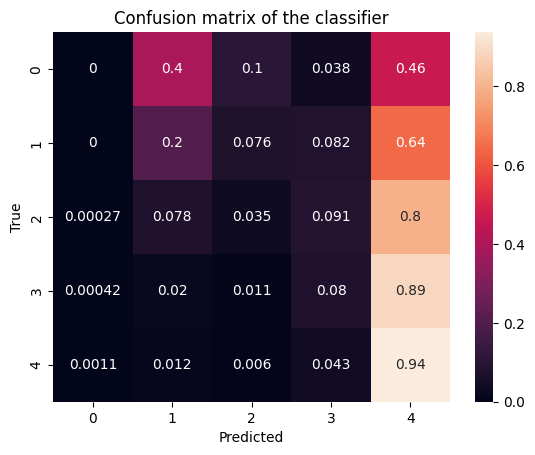

In [38]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# Load training set with new features into DataFrame
X_train = pd.read_csv("./data/X_train.csv")

# Split training set into training and testing set
X_train, X_test, Y_train, Y_test = train_test_split(
        X_train.drop(['Score'], axis=1),
        X_train['Score'],
        test_size=1/4.0,
        random_state=0
    )

# This is where you can do more feature selection
X_train_processed = X_train.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time'])
X_test_processed = X_test.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Time'])

model = LogisticRegression(class_weight={2.0: 4, 3.0: 3, 4.0: 4, 5.0: 3})
model.fit(X_train_processed, Y_train)

# pickle model - saves it so you can load it later
with open('logistic_model.obj', 'wb') as f:
    pickle.dump(model, f)
# to load pickled model: 
# with open('filename', 'rb') as f:
#    model = pickle.load(f)

# Evaluate your model on the testing set
Y_test_predictions = model.predict(X_test_processed)
print("Accuracy on testing set = ", accuracy_score(Y_test, Y_test_predictions))
print("RMSE on testing set = ", mean_squared_error(Y_test, Y_test_predictions, squared=False))


# Plot a confusion matrix
cm = confusion_matrix(Y_test, Y_test_predictions, normalize='true')
sns.heatmap(cm, annot=True)
plt.title('Confusion matrix of the classifier')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [33]:
X_submission = pd.read_csv("./data/X_test.csv")
X_submission_processed = X_submission.drop(columns=['Id', 'ProductId', 'UserId', 'Text', 'Summary', 'Score', 'Time'])

X_submission['Score'] = model.predict(X_submission_processed)
submission = X_submission[['Id', 'Score']]
submission.to_csv("./data/submission.csv", index=False)